# Download Matbench datasets

In [4]:
import os
from matminer.datasets import load_dataset
from pymatgen.core.composition import Composition

  
# Creating a directory to save datasets.    (https://www.geeksforgeeks.org/create-a-directory-in-python/)
directory_dataset = "MatBench_datasets"
parent_dir = "C:\\Users\\Hasan Sayeed\\Documents\\hasan\\TI\\form\\CBFV_new\\"
path = os.path.join(parent_dir, directory_dataset)
os.mkdir(path)
save_path_dataset = "C:\\Users\\Hasan Sayeed\\Documents\\hasan\\TI\\form\\CBFV_new\\{}".format(directory_dataset)


# Download datasets from Matbench that's input is 'structure'.

tasks_structure = {'matbench_jdft2d': 'exfoliation_en', 'matbench_phonons': 'last phdos peak', 'matbench_dielectric': 'n', 'matbench_log_gvrh': 'log10(G_VRH)',
         'matbench_log_kvrh': 'log10(K_VRH)', 'matbench_perovskites': 'e_form', 'matbench_mp_gap': 'gap pbe', 'matbench_mp_is_metal': 'is_metal',
         'matbench_mp_e_form': 'e_form'}

for index, (key, value) in enumerate(tasks_structure.items()):
    df = load_dataset(key)

    formula = []
    for s in df.structure:
        formula.append(s.formula)

    df['formula'] = formula
    del df['structure']
    df = df.rename({value: 'target'}, axis=1)
    df = df[['formula', 'target']]
    df.to_csv(os.path.join(save_path_dataset, '{}.csv'.format(key)), index = False)
    

# Download datasets from Matbench that's input is 'composition'.

tasks_composition = {'matbench_steels': 'yield strength', 'matbench_expt_gap': 'gap expt', 'matbench_expt_is_metal': 'is_metal', 'matbench_glass': 'gfa'}

for index, (key, value) in enumerate(tasks_composition.items()):
    df = load_dataset(key)

    formula = []
    for s in df.composition:
        formula.append(Composition(s).formula)

    df['formula'] = formula
    del df['composition']
    df = df.rename({value: 'target'}, axis=1)
    df = df[['formula', 'target']]
    df.to_csv(os.path.join(save_path_dataset, '{}.csv'.format(key)), index = False)

Fetching matbench_phonons.json.gz from https://ndownloader.figshare.com/files/17476037 to C:\Users\Hasan Sayeed\AppData\Roaming\Python\Python38\site-packages\matminer\datasets\matbench_phonons.json.gz
Fetching matbench_dielectric.json.gz from https://ndownloader.figshare.com/files/17476067 to C:\Users\Hasan Sayeed\AppData\Roaming\Python\Python38\site-packages\matminer\datasets\matbench_dielectric.json.gz
Fetching matbench_log_gvrh.json.gz from https://ndownloader.figshare.com/files/17476064 to C:\Users\Hasan Sayeed\AppData\Roaming\Python\Python38\site-packages\matminer\datasets\matbench_log_gvrh.json.gz
Fetching matbench_log_kvrh.json.gz from https://ndownloader.figshare.com/files/17476061 to C:\Users\Hasan Sayeed\AppData\Roaming\Python\Python38\site-packages\matminer\datasets\matbench_log_kvrh.json.gz
Fetching matbench_mp_e_form.json.gz from https://ndownloader.figshare.com/files/17476028 to C:\Users\Hasan Sayeed\AppData\Roaming\Python\Python38\site-packages\matminer\datasets\matbench

# Run Regression tasks

In [67]:
import pandas as pd
import xgboost as xgb
from cbfv.composition import generate_features
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import uniform, randint

#   Helper function
def evaluate_model_hpsearch(model, model_name, X_train, y_train):
    y_pred = model.predict(X_train)
    r2 = r2_score(y_train, y_pred)
    mae = mean_absolute_error(y_train, y_pred)
    rmse = mean_squared_error(y_train, y_pred, squared=False)
    
    result_dict = {
        'model_name': model_name,
        'model_name_pretty': type(model).__name__,
        'model_params': model.get_params(),
        'r2': r2,
        'mae': mae,
        'rmse': rmse}
    return model, result_dict

def evaluate_model(model, model_name, descriptor, percentage, X_train, y_train, X_val, y_val):
    y_pred_train = model.predict(X_train)
    r2_train = r2_score(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    
    y_pred_val = model.predict(X_val)
    r2_val = r2_score(y_val, y_pred_val)
    mae_val = mean_absolute_error(y_val, y_pred_val)
    rmse_val = mean_squared_error(y_val, y_pred_val, squared=False)
    
    result_dict = {
        #'Percentage of data': (1-percentage)*100,
        'model_name': model_name,
        'model_name_pretty': type(model).__name__,
        'model_params': model.get_params(),
        'r2_train': r2_train,
        'mae_train': mae_train,
        'rmse_train': rmse_train,
        'r2_val': r2_val,
        'mae_val': mae_val,
        'rmse_val': rmse_val}
    return model, result_dict


  
# Creating a directory to save results.
directory_results = "results"
path = os.path.join(parent_dir, directory_results)
os.mkdir(path)
save_path_results = "C:\\Users\\Hasan Sayeed\\Documents\\hasan\\TI\\form\\CBFV_new\\{}".format(directory_results)


regression_tasks = ['matbench_jdft2d', 'matbench_phonons', 'matbench_dielectric', 'matbench_log_gvrh',
                    'matbench_log_kvrh', 'matbench_perovskites', 'matbench_mp_gap', 'matbench_mp_e_form']#, 'matbench_expt_gap', 'matbench_steels']

for task in regression_tasks:

    #Reading from csv, CBFV, scaling
    df = pd.read_csv('Matbench_datasets/{}.csv'.format(task))
    X, y, formulae, skipped = generate_features(df, elem_prop='new_mat2vec_element_vectors', drop_duplicates=True)
    X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=42)

    #   Scaling and normalizing
    scaler = StandardScaler()
    X_train = normalize(scaler.fit_transform(X_train_unscaled))
    X_test = normalize(scaler.transform(X_test_unscaled))

    # Base
    X_O, y_O, formulae_O, skipped_O = generate_features(df, elem_prop='onehot', drop_duplicates=True)


    #   Hyperparameter tuning
    xgb_model = xgb.XGBRegressor(objective="reg:linear")

    params = {
        "max_depth": randint(4, 12), # default 3
        "learning_rate": uniform(0.03, 0.3), # default 0.1
        "colsample_bytree": uniform(0.7, 0.3),
        "min_child_weight": uniform(0.05, 0.2),
        "reg_lambda": uniform(0.7, 2.0),
        "colsample_bynode": uniform(0.7, 0.3),
        "n_estimators": randint(120, 170),
    }

    search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=10, cv=10, verbose=1, n_jobs=7, return_train_score=True)
    search.fit(X_train, y_train)

    '''
    # To get results from the best model.
    search.best_estimator_
    best_model = search.best_estimator_.fit(X_train, y_train)
    model, result_dict = evaluate_model_hpsearch(best_model, 'XGBoost', X_train, y_train)
    result_dict
    '''


    #   mat2vec

    numbers = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000] 

    #percentage = [round((1-p)*100, 1) for p in percentages]
    N_datapoints = []
    r2 = []
    mae = []
    rmse = []

    for n in numbers:
        if len(X) < n:
            break 
        X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X, y, train_size=n, random_state=42)

        #   Scaling and normalizing
        scaler = StandardScaler()

        X_train = normalize(scaler.fit_transform(X_train_unscaled))
        X_test = normalize(scaler.transform(X_test_unscaled))

        best_model = search.best_estimator_.fit(X_train, y_train)
        model, result_dict = evaluate_model(best_model, 'XGBoost', 'mat2vec', p, X_train, y_train, X_test, y_test)
        N_datapoints.append(len(X_train))
        r2.append(result_dict['r2_val'])
        mae.append(result_dict['mae_val'])
        rmse.append(result_dict['rmse_val'])
        #result_dict


    #   base model

    r2_base = []
    mae_base = []
    rmse_base = []

    for n in numbers:
        if len(X_O) < n:
            break
        X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X_O, y_O, train_size=n, random_state=42)

        #   Scaling and normalizing
        scaler = StandardScaler()

        X_train = normalize(scaler.fit_transform(X_train_unscaled))
        X_test = normalize(scaler.transform(X_test_unscaled))

        best_model = search.best_estimator_.fit(X_train, y_train)
        model, result_dict = evaluate_model(best_model, 'XGBoost', 'onehot', 100-p*10, X_train, y_train, X_test, y_test)
        r2_base.append(result_dict['r2_val'])
        mae_base.append(result_dict['mae_val'])
        rmse_base.append(result_dict['rmse_val'])
        #result_dict


    #   Writing results in a csv

    result_list = pd.DataFrame(
        {'N_datapoints': N_datapoints,
         'r2': r2,
         'r2_base': r2_base,
         'mae': mae,
         'mae_base': mae_base,
         'rmse': rmse,
         'rmse_base': rmse_base
        })
    result_list.to_csv(os.path.join(save_path_results, 'result {}.csv'.format(task)), index = False)


    '''From lists to dataframe
    https://stackoverflow.com/questions/30522724/take-multiple-lists-into-dataframe'''

Processing Input Data: 100%|██████████████████████████████████████████████████████| 581/581 [00:00<00:00, 34323.85it/s]

Duplicate formula(e) removed using default pandas function
	Featurizing Compositions...
	Creating Pandas Objects...



Assigning Features...: 100%|██████████████████████████████████████████████████████| 581/581 [00:00<00:00, 25298.37it/s]
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


	Featurizing Compositions...
	Creating Pandas Objects...
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    1.5s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    4.8s finished


[10:36:32] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:36:32] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:36:32] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:36:32] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:36:33] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:36:33] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:36:34] WARNING: d:\bld\xgboost-split_1631904903843\work\src\

Assigning Features...: 100%|████████████████████████████████████████████████████| 1223/1223 [00:00<00:00, 17638.58it/s]

Duplicate formula(e) removed using default pandas function
	Featurizing Compositions...
	Creating Pandas Objects...



Assigning Features...: 100%|████████████████████████████████████████████████████| 1223/1223 [00:00<00:00, 24525.51it/s]
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


	Featurizing Compositions...
	Creating Pandas Objects...
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    2.5s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    7.3s finished


[10:36:42] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:36:43] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:36:43] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:36:43] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:36:43] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:36:44] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:36:44] WARNING: d:\bld\xgboost-split_1631904903843\work\src\

Processing Input Data: 100%|████████████████████████████████████████████████████| 4359/4359 [00:00<00:00, 26650.40it/s]

Duplicate formula(e) removed using default pandas function



Assigning Features...:  98%|██████████████████████████████████████████████████▉ | 4274/4359 [00:00<00:00, 21226.17it/s]

	Featurizing Compositions...


Processing Input Data:   0%|                                                                  | 0/4359 [00:00<?, ?it/s]

	Creating Pandas Objects...


Assigning Features...: 100%|████████████████████████████████████████████████████| 4359/4359 [00:00<00:00, 24829.39it/s]

	Featurizing Compositions...



[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


	Creating Pandas Objects...
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    6.8s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:   19.3s finished


[10:37:15] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:16] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:16] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:16] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:17] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:17] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:18] WARNING: d:\bld\xgboost-split_1631904903843\work\src\

[10:38:34] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:38:34] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:38:34] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:38:35] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:38:35] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:38:36] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:38:37] WARNING: d:\bld\xgboost-split_1631904903843\work\src\

Processing Input Data:  26%|█████████████▏                                     | 2707/10432 [00:00<00:00, 26873.33it/s]

Duplicate formula(e) removed using default pandas function


Assigning Features...:  42%|█████████████████████▌                             | 4418/10432 [00:00<00:00, 21947.66it/s]

	Featurizing Compositions...


Assigning Features...: 100%|██████████████████████████████████████████████████| 10432/10432 [00:00<00:00, 21763.61it/s]


	Creating Pandas Objects...


Assigning Features...:  25%|████████████▌                                      | 2560/10432 [00:00<00:00, 25407.33it/s]

	Featurizing Compositions...


Assigning Features...: 100%|██████████████████████████████████████████████████| 10432/10432 [00:00<00:00, 25140.43it/s]


	Creating Pandas Objects...
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   14.6s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:   40.5s finished


[10:39:48] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:39:49] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:39:49] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:39:50] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:39:50] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:39:51] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:39:51] WARNING: d:\bld\xgboost-split_1631904903843\work\src\

[10:41:59] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:42:04] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:42:09] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:42:13] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:42:18] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:42:24] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:42:29] WARNING: d:\bld\xgboost-split_1631904903843\work\src\

[10:45:00] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:45:01] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:45:02] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:45:03] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:45:04] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:45:06] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:45:07] WARNING: d:\bld\xgboost-split_1631904903843\work\src\

[10:46:53] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:56] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


Processing Input Data:  27%|█████████████▌                                     | 2772/10432 [00:00<00:00, 27518.93it/s]

Duplicate formula(e) removed using default pandas function


Assigning Features...:  21%|██████████▋                                        | 2185/10432 [00:00<00:00, 21685.45it/s]

	Featurizing Compositions...


Assigning Features...: 100%|██████████████████████████████████████████████████| 10432/10432 [00:00<00:00, 21948.91it/s]


	Creating Pandas Objects...


Assigning Features...:  24%|████████████▏                                      | 2487/10432 [00:00<00:00, 24689.60it/s]

	Featurizing Compositions...


Assigning Features...: 100%|██████████████████████████████████████████████████| 10432/10432 [00:00<00:00, 25081.44it/s]


	Creating Pandas Objects...
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   15.6s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:   41.4s finished


[10:47:43] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:47:44] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:47:44] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:47:44] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:47:45] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:47:45] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:47:46] WARNING: d:\bld\xgboost-split_1631904903843\work\src\

[10:49:50] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:49:54] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:49:59] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:50:04] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:50:08] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:50:13] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:50:18] WARNING: d:\bld\xgboost-split_1631904903843\work\src\

[10:52:44] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:52:45] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:52:46] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:52:47] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:52:48] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:52:50] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:52:51] WARNING: d:\bld\xgboost-split_1631904903843\work\src\

[10:54:33] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:54:36] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


Processing Input Data:  26%|█████████████▌                                      | 2544/9723 [00:00<00:00, 25255.29it/s]

Duplicate formula(e) removed using default pandas function


Assigning Features...:  21%|██████████▊                                         | 2016/9723 [00:00<00:00, 20007.14it/s]

	Featurizing Compositions...


Assigning Features...: 100%|████████████████████████████████████████████████████| 9723/9723 [00:00<00:00, 19935.46it/s]


	Creating Pandas Objects...


Assigning Features...:  25%|████████████▊                                       | 2400/9723 [00:00<00:00, 23819.43it/s]

	Featurizing Compositions...


Assigning Features...: 100%|████████████████████████████████████████████████████| 9723/9723 [00:00<00:00, 24010.69it/s]
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


	Creating Pandas Objects...
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   15.7s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:   42.1s finished


[10:55:24] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:55:24] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:55:24] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:55:25] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:55:25] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:55:26] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:55:26] WARNING: d:\bld\xgboost-split_1631904903843\work\src\

[10:57:36] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:57:41] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:57:46] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:57:51] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:57:56] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:58:01] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:58:07] WARNING: d:\bld\xgboost-split_1631904903843\work\src\

[11:00:39] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:00:40] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:00:41] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:00:42] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:00:43] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:00:44] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:00:45] WARNING: d:\bld\xgboost-split_1631904903843\work\src\

[11:02:07] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:02:09] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


Processing Input Data:   4%|█▊                                                 | 3130/87264 [00:00<00:02, 31013.94it/s]

Duplicate formula(e) removed using default pandas function


Assigning Features...:   5%|██▍                                                | 4163/87264 [00:00<00:04, 20689.42it/s]

	Featurizing Compositions...


Assigning Features...: 100%|██████████████████████████████████████████████████| 87264/87264 [00:04<00:00, 20688.80it/s]


	Creating Pandas Objects...


Assigning Features...:   3%|█▍                                                 | 2496/87264 [00:00<00:03, 24779.19it/s]

	Featurizing Compositions...


Assigning Features...: 100%|██████████████████████████████████████████████████| 87264/87264 [00:03<00:00, 24639.14it/s]


	Creating Pandas Objects...
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:  2.7min
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:  6.8min finished


[11:09:16] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:09:20] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:09:21] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:09:22] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:09:23] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:09:25] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:09:26] WARNING: d:\bld\xgboost-split_1631904903843\work\src\

[11:12:02] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:12:07] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:12:12] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:12:18] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:12:24] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:12:29] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:12:35] WARNING: d:\bld\xgboost-split_1631904903843\work\src\

[11:15:28] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:15:30] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:15:31] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:15:33] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:15:35] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:15:36] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:15:38] WARNING: d:\bld\xgboost-split_1631904903843\work\src\

[11:17:39] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:17:43] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


Processing Input Data:   6%|███▏                                              | 6757/106253 [00:00<00:02, 33752.78it/s]

Duplicate formula(e) removed using default pandas function


Assigning Features...:   2%|█                                                 | 2162/106253 [00:00<00:04, 21463.18it/s]

	Featurizing Compositions...


Assigning Features...: 100%|████████████████████████████████████████████████| 106253/106253 [00:05<00:00, 20697.05it/s]


	Creating Pandas Objects...


Assigning Features...:   2%|█▏                                                | 2557/106253 [00:00<00:04, 25377.62it/s]

	Featurizing Compositions...


Assigning Features...: 100%|████████████████████████████████████████████████| 106253/106253 [00:04<00:00, 24690.87it/s]


	Creating Pandas Objects...
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:  3.2min
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:  8.1min finished


[11:26:14] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:26:20] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:26:21] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:26:22] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:26:23] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:26:24] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:26:26] WARNING: d:\bld\xgboost-split_1631904903843\work\src\

[11:29:08] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:13] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:19] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:24] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:30] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:36] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:42] WARNING: d:\bld\xgboost-split_1631904903843\work\src\

[11:32:39] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:32:40] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:32:42] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:32:44] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:32:45] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:32:47] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:32:49] WARNING: d:\bld\xgboost-split_1631904903843\work\src\

[11:34:56] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:59] WARNING: d:\bld\xgboost-split_1631904903843\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


In [68]:
result_list

,N_datapoints,r2,r2_base,mae,mae_base,rmse,rmse_base
0,100,0.589104,0.427417,0.545763,0.645091,0.746902,0.881693
1,200,0.648239,0.598351,0.491094,0.542092,0.691064,0.738444
2,300,0.714772,0.656805,0.442871,0.489367,0.622301,0.682613
3,400,0.733574,0.687427,0.424377,0.461303,0.601466,0.651476
4,500,0.742191,0.724984,0.419938,0.431070,0.591634,0.611060
...,...,...,...,...,...,...,...
75,7600,0.866368,0.850518,0.274997,0.302257,0.425801,0.450344
76,7700,0.866598,0.850721,0.275627,0.301942,0.425424,0.450029
77,7800,0.866747,0.851295,0.275452,0.301268,0.425163,0.449137
78,7900,0.868977,0.852263,0.273613,0.300385,0.421542,0.447623


# Graph

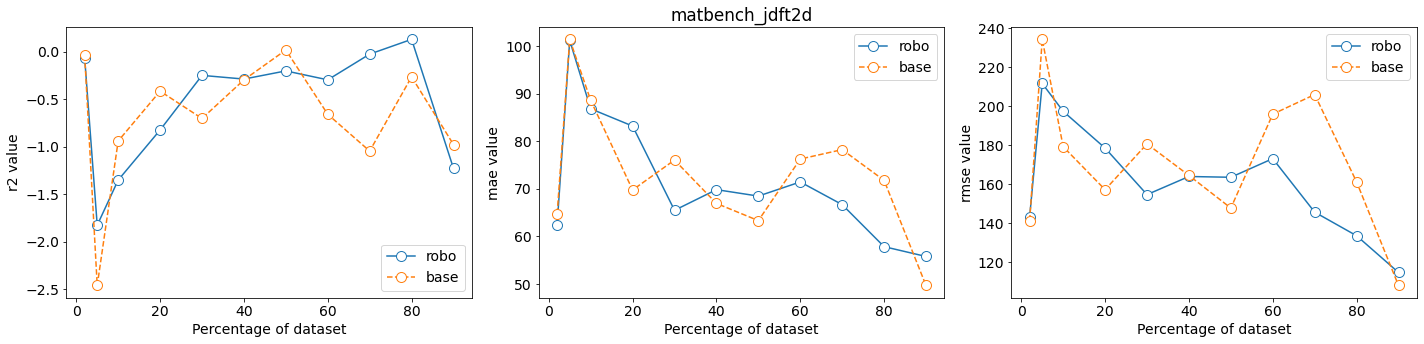

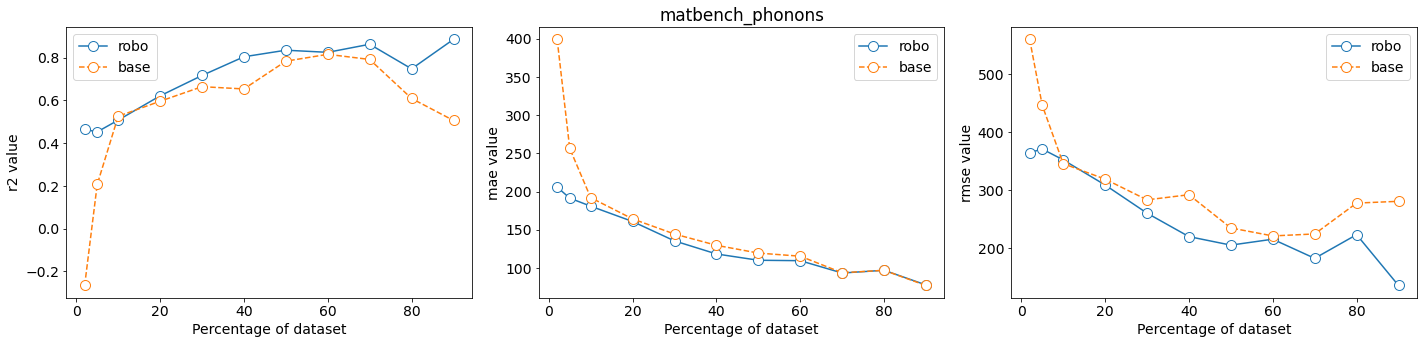

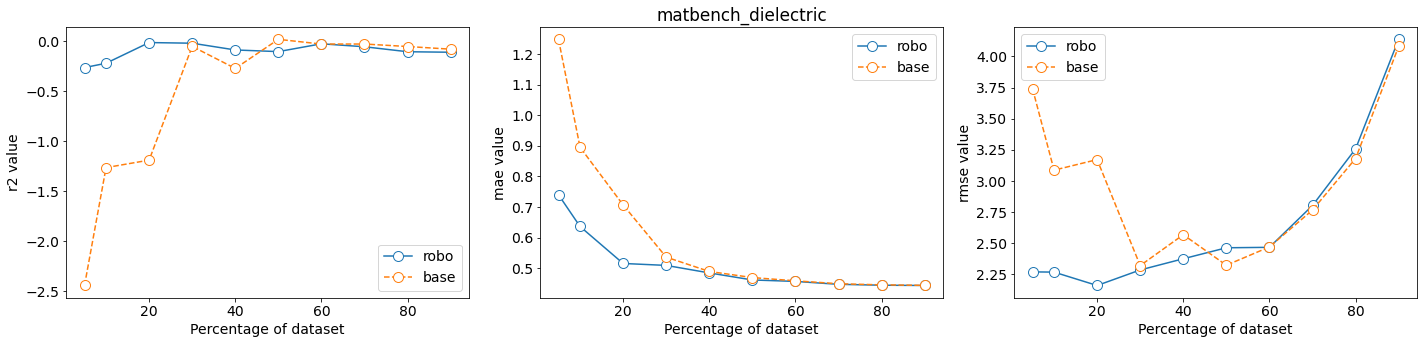

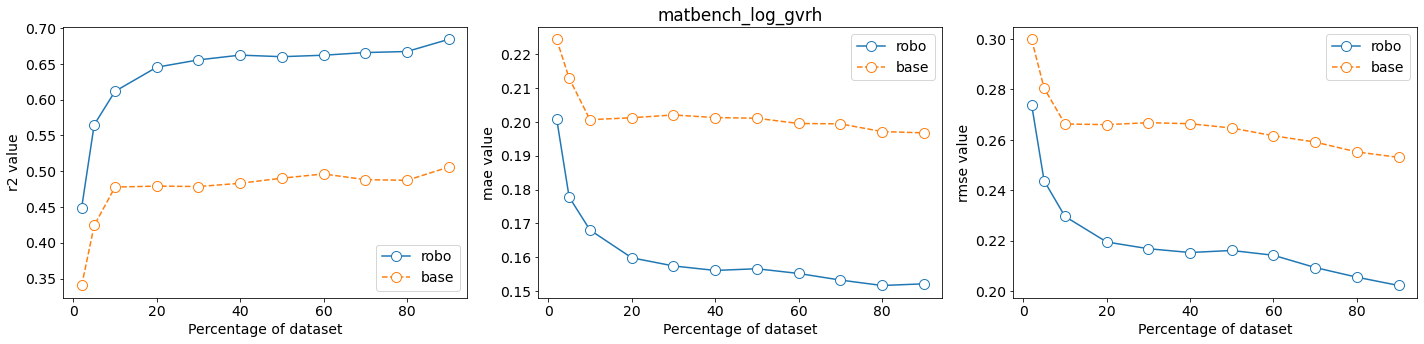

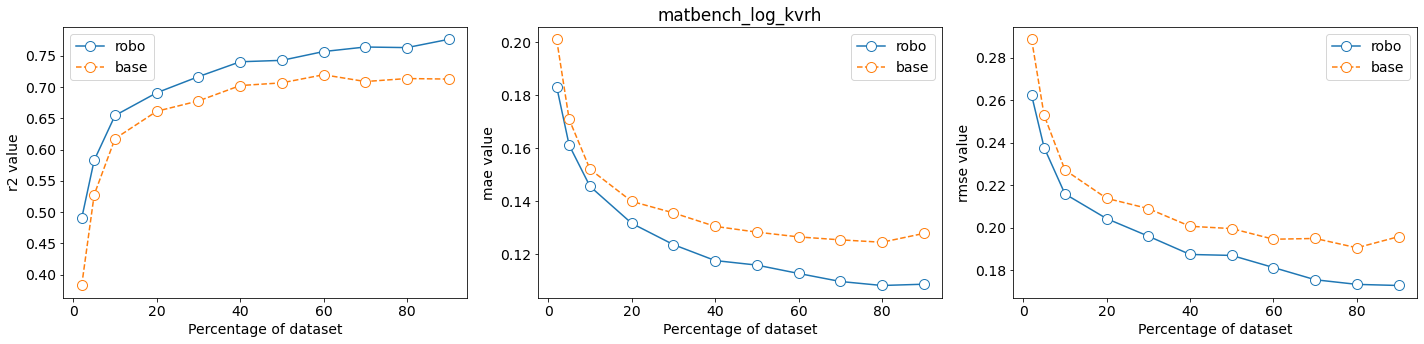

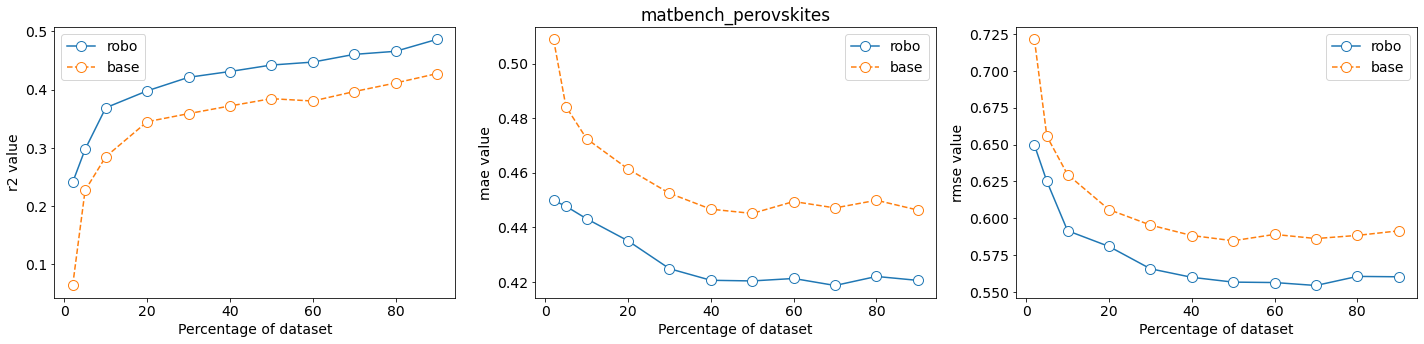

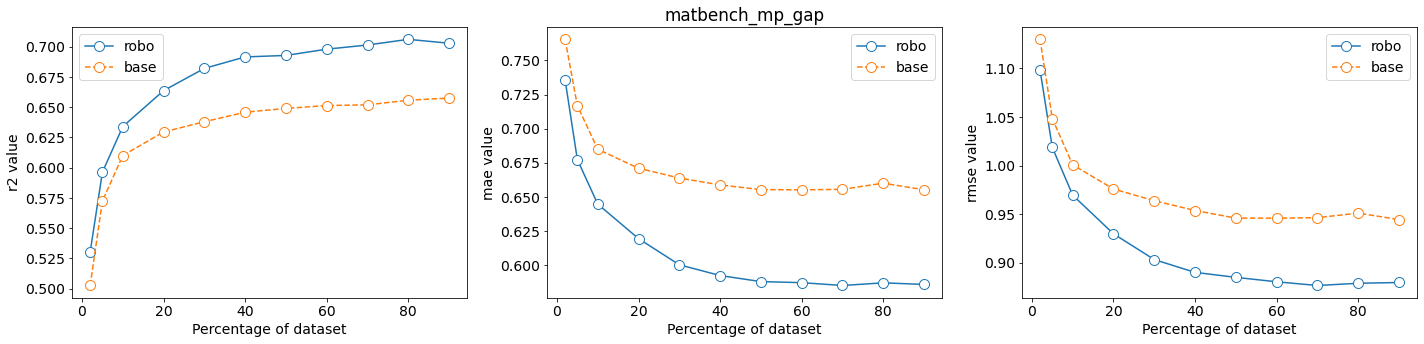

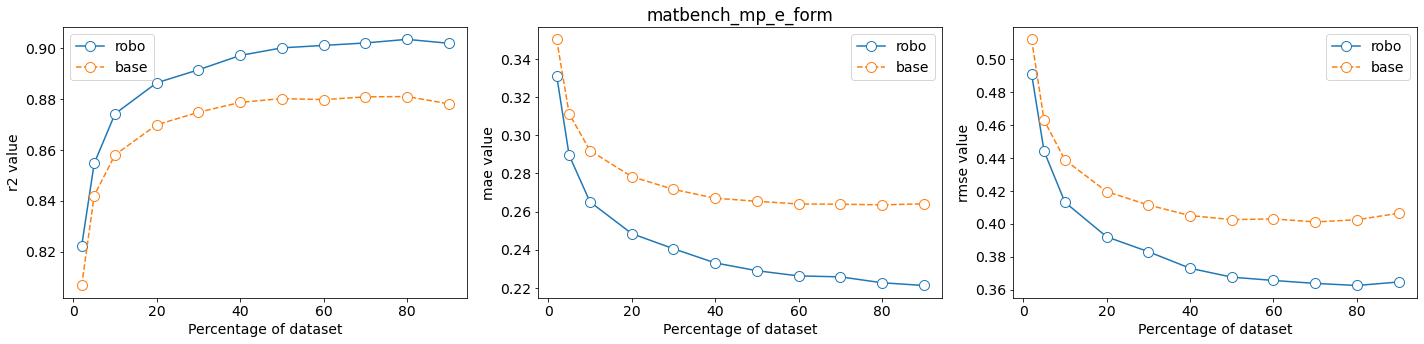

In [75]:
import numpy as np
from matplotlib import pyplot as plt
#plt.rcParams.update({'font.size' : 14})

for task in regression_tasks:
    df_graph = pd.read_csv('results_new_5_percent/result {}.csv'.format(task))
    #df_graph = pd.read_csv('results/result matbench_perovskites.csv')
    df_x = df_graph['percentage']
    df_y_r2 = df_graph['r2']
    df_y_r2_base = df_graph['r2_base']
    df_y_mae = df_graph['mae']
    df_y_mae_base = df_graph['mae_base']
    df_y_rmse = df_graph['rmse']
    df_y_rmse_base = df_graph['rmse_base']



    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3 ,figsize=(20,5))
    #fig = plt.figure(constrained_layout=True)
    #plt.figure(figsize=(14,5))

    ax1.plot(df_x, df_y_r2, marker='o', markersize=10, mfc= 'white', linestyle='solid', label='robo')
    ax1.plot(df_x, df_y_r2_base, marker='o', markersize=10, mfc= 'white', linestyle='dashed', label='base')

    ax2.plot(df_x, df_y_mae, marker='o', markersize=10, mfc= 'white', linestyle='solid', label='robo')
    ax2.plot(df_x, df_y_mae_base, marker='o', markersize=10, mfc= 'white', linestyle='dashed', label='base')

    ax3.plot(df_x, df_y_rmse, marker='o', markersize=10, mfc= 'white', linestyle='solid', label='robo')
    ax3.plot(df_x, df_y_rmse_base, marker='o', markersize=10, mfc= 'white', linestyle='dashed', label='base')

    ax1.legend()
    #ax1.set_title('change of r2 with dataset size')
    ax1.set_xlabel('Percentage of dataset')
    ax1.set_ylabel('r2 value')

    ax2.legend()
    ax2.set_title('{}'.format(task))
    ax2.set_xlabel('Percentage of dataset')
    ax2.set_ylabel('mae value')

    ax3.legend()
    #ax3.set_title('change of rmse with dataset size')
    ax3.set_xlabel('Percentage of dataset')
    ax3.set_ylabel('rmse value')

    '''x_1 = [90, 80, 70, 60, 50, 40, 30, 20, 10, 5, 2]

    y_1 = [12, 13, 13, 14, 14, 15, 15, 16, 17, 18, 19]
    y_2_base = [14,14,14,15,16,16,16,17,18,20,20]'''


    #fig = plt.figure(1, figsize=(6,5))
    '''plt.plot(df_x, df_y_r2, marker='o', markersize=10, mfc= 'white', linestyle='--', label='robo')
    plt.plot(df_x, df_y_r2_base, marker='s', markersize=10, mfc= 'white', linestyle='--', label='base')

    plt.title('my plot')
    plt.xlabel('Percentage of dataset')
    plt.ylabel('Error (%)')
    plt.legend()'''
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(save_path_results,'{}.png'.format(task)))

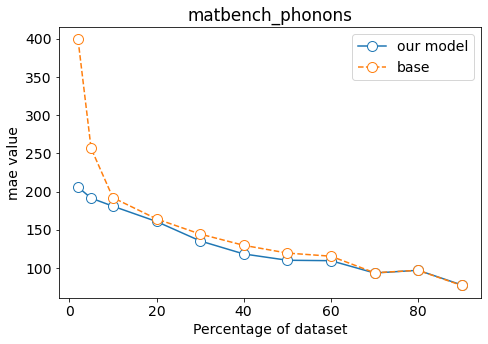

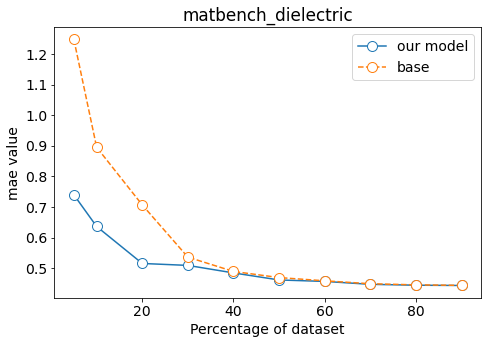

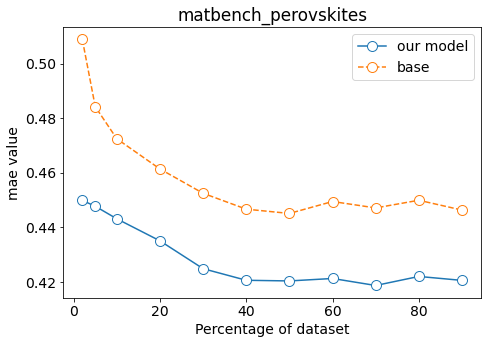

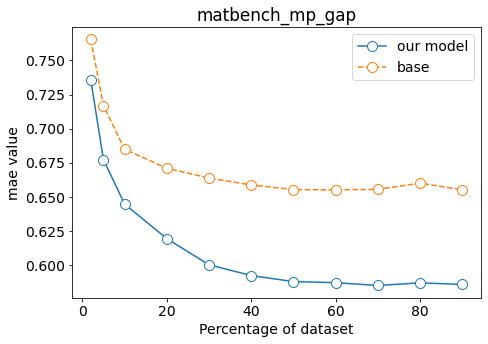

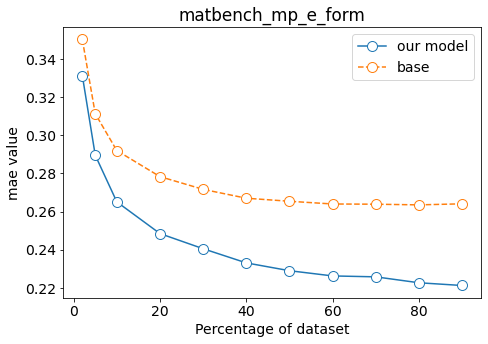

In [83]:
import numpy as np
from matplotlib import pyplot as plt
#plt.rcParams.update({'font.size' : 14})

later_tasks = ['matbench_phonons', 'matbench_dielectric','matbench_perovskites', 'matbench_mp_gap', 'matbench_mp_e_form']

for task in later_tasks:
    df_graph = pd.read_csv('results_new_5_percent/result {}.csv'.format(task))
    #df_graph = pd.read_csv('results/result matbench_perovskites.csv')
    df_x = df_graph['percentage']
    df_y_r2 = df_graph['r2']
    df_y_r2_base = df_graph['r2_base']
    df_y_mae = df_graph['mae']
    df_y_mae_base = df_graph['mae_base']
    df_y_rmse = df_graph['rmse']
    df_y_rmse_base = df_graph['rmse_base']



    fig, ax1 = plt.subplots(nrows=1, ncols=1 ,figsize=(7,5))
    #fig = plt.figure(constrained_layout=True)
    #plt.figure(figsize=(14,5))

    ax1.plot(df_x, df_y_mae, marker='o', markersize=10, mfc= 'white', linestyle='solid', label='our model')
    ax1.plot(df_x, df_y_mae_base, marker='o', markersize=10, mfc= 'white', linestyle='dashed', label='base')

    '''ax2.plot(df_x, df_y_mae, marker='o', markersize=10, mfc= 'white', linestyle='solid', label='robo')
    ax2.plot(df_x, df_y_mae_base, marker='o', markersize=10, mfc= 'white', linestyle='dashed', label='base')

    ax3.plot(df_x, df_y_rmse, marker='o', markersize=10, mfc= 'white', linestyle='solid', label='robo')
    ax3.plot(df_x, df_y_rmse_base, marker='o', markersize=10, mfc= 'white', linestyle='dashed', label='base')'''

    ax1.legend()
    ax1.set_title('{}'.format(task))
    ax1.set_xlabel('Percentage of dataset')
    ax1.set_ylabel('mae value')

    '''ax2.legend()
    ax2.set_title('{}'.format(task))
    ax2.set_xlabel('Percentage of dataset')
    ax2.set_ylabel('mae value')

    ax3.legend()
    #ax3.set_title('change of rmse with dataset size')
    ax3.set_xlabel('Percentage of dataset')
    ax3.set_ylabel('rmse value')'''

   
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(save_path_results,'{}.png'.format(task)))